In [22]:
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Import Google Semantic Data

In [26]:
# Load file and filter out all non-acitivty segments
months = ['JANUARY','FEBRUARY','MARCH','MAY','JUNE','JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']
years = ['2014','2015','2016']

data = []
for year in years:
    for month in months:
        m = month
        if year == '2014':
            m = 'DECEMBER'
        if year == '2016':
            m = 'JANUARY'
        with open('GoogleLocationHistory/Takeout/Location History/Semantic Location History/{}/{}_{}.json'.format(year,year, m)) as f:
            curr = json.load(f)
        curr = curr['timelineObjects']
        curr = [x['activitySegment'] for x in curr if 'activitySegment' in x]
        data.extend(curr)
        if year == "2016" and month != "JANUARY" and month != "FEBRUARY" and month != "MARCH":
            with open('GoogleLocationHistory/Takeout/Location History/Semantic Location History/NamanSemantic/2016_{}.json'.format(month)) as f:
                curr = json.load(f)
            curr = curr['timelineObjects']
            curr = [x['activitySegment'] for x in curr if 'activitySegment' in x]
            data.extend(curr)

In [29]:
df = pd.DataFrame(data)
df.head()

,startLocation,endLocation,duration,activityType,activities,simplifiedRawPath,confidence,waypointPath,editConfirmationStatus,distance,transitPath
0,"{'latitudeE7': 403539256, 'longitudeE7': -7527...","{'latitudeE7': 399563620, 'longitudeE7': -7487...","{'startTimestampMs': '1419120901134', 'endTime...",UNKNOWN_ACTIVITY_TYPE,"[{'activityType': 'UNKNOWN_ACTIVITY_TYPE', 'pr...","{'points': [{'latE7': 401496559, 'lngE7': -750...",NaN,NaN,NaN,NaN,NaN
1,"{'latitudeE7': 399563620, 'longitudeE7': -7487...","{'latitudeE7': 400105079, 'longitudeE7': -7558...","{'startTimestampMs': '1419132912091', 'endTime...",UNKNOWN_ACTIVITY_TYPE,"[{'activityType': 'UNKNOWN_ACTIVITY_TYPE', 'pr...","{'points': [{'latE7': 400486992, 'lngE7': -755...",NaN,NaN,NaN,NaN,NaN
2,"{'latitudeE7': 400105079, 'longitudeE7': -7558...","{'latitudeE7': 400238167, 'longitudeE7': -7562...","{'startTimestampMs': '1419194024865', 'endTime...",UNKNOWN_ACTIVITY_TYPE,"[{'activityType': 'UNKNOWN_ACTIVITY_TYPE', 'pr...","{'points': [{'latE7': 400120466, 'lngE7': -755...",NaN,NaN,NaN,NaN,NaN
3,"{'latitudeE7': 400238167, 'longitudeE7': -7562...","{'latitudeE7': 399985533, 'longitudeE7': -7556...","{'startTimestampMs': '1419199507603', 'endTime...",UNKNOWN_ACTIVITY_TYPE,"[{'activityType': 'UNKNOWN_ACTIVITY_TYPE', 'pr...","{'points': [{'latE7': 400236795, 'lngE7': -756...",NaN,NaN,NaN,NaN,NaN
4,"{'latitudeE7': 399985533, 'longitudeE7': -7556...","{'latitudeE7': 400106500, 'longitudeE7': -7558...","{'startTimestampMs': '1419203248778', 'endTime...",UNKNOWN_ACTIVITY_TYPE,"[{'activityType': 'UNKNOWN_ACTIVITY_TYPE', 'pr...","{'points': [{'latE7': 400091622, 'lngE7': -755...",NaN,NaN,NaN,NaN,NaN


# Clean Data

In [30]:
df.duration = df.duration.apply(lambda x: int(x['endTimestampMs']) - df.duration.apply(lambda x: int(x['startTimestampMs'])))
df.activities = df.activities.apply(lambda x: x[0]['activityType'])

In [51]:
simple = df[['duration', 'distance', 'activities']]
simple = simple.dropna()
simple['speed'] = simple['distance']/simple['duration']
simple.head()

,duration,distance,activities,speed
56,4241344424,8020.0,IN_VEHICLE,1.890910e-06
57,4302949291,7634.0,IN_VEHICLE,1.774132e-06
58,4311089583,7838.0,IN_VEHICLE,1.818102e-06
59,4362641115,3887.0,CYCLING,8.909740e-07
60,4391139804,481.0,UNKNOWN_ACTIVITY_TYPE,1.095388e-07


In [52]:
simple.activities.value_counts()

WALKING                  1017
IN_PASSENGER_VEHICLE      712
IN_VEHICLE                414
IN_TRAIN                  108
UNKNOWN_ACTIVITY_TYPE      35
IN_BUS                     28
CYCLING                    20
MOTORCYCLING               10
IN_SUBWAY                   3
FLYING                      2
RUNNING                     1
Name: activities, dtype: int64

# Split Data, Train Model, and Evaluate

RBF SVM: 48.723404255319146
Random Forest: 79.14893617021276
Multi-Layer Perceptron: 71.27659574468085


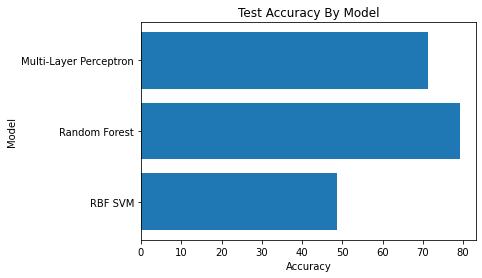

In [90]:
x_train, x_test, y_train, y_test = train_test_split(simple[['duration','distance', 'speed']], simple['activities'], test_size = 0.2)
names = ["RBF SVM", "Random Forest", "Multi-Layer Perceptron"]

classifiers = [
    make_pipeline(StandardScaler(), SVC(C=3, gamma=0.1)),
    RandomForestClassifier(),
    make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, hidden_layer_sizes=(50, 50, 50)))]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test) * 100
    print(name + ": " + str(score))
    scores.append(score)
    
plt.barh(names,
scores, align='center')

plt.ylabel('Model')
plt.xlabel('Accuracy')
plt.title('Test Accuracy By Model')

plt.show()

81.06382978723404
171


Text(0, 0.5, 'Accuracy')

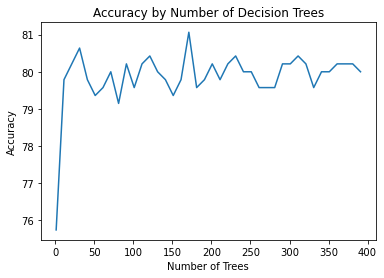

In [91]:
num_trees = []
acc = []
hi = 0
max_i = 0
for i in range(1, 401, 10):
    c = RandomForestClassifier(n_estimators=i)
    c.fit(x_train, y_train)
    score = c.score(x_test, y_test) * 100
    if score > hi:
        hi = score
        max_i = i
    acc.append(score)
    num_trees.append(i)
print(hi)
print(max_i)
plt.plot(num_trees, acc)
plt.title("Accuracy by Number of Decision Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")

81.70212765957446
13


Text(0, 0.5, 'Accuracy')

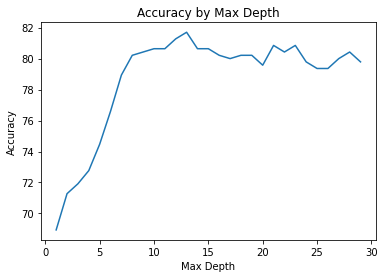

In [92]:
max_depth = []
acc = []
hi1 = 0
max_i1 = 0
for i in range(1, 30):
    c = RandomForestClassifier(max_depth=i)
    c.fit(x_train, y_train)
    score = c.score(x_test, y_test) * 100
    if score > hi1:
        hi1 = score
        max_i1 = i
    acc.append(score)
    max_depth.append(i)
print(hi1)
print(max_i1)
plt.plot(max_depth, acc)
plt.title("Accuracy by Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

In [93]:
predicted = c.predict(x_test)
print(f"{classification_report(y_test, predicted)}\n")

                       precision    recall  f1-score   support

              CYCLING       0.00      0.00      0.00         6
               IN_BUS       0.00      0.00      0.00         3
 IN_PASSENGER_VEHICLE       0.81      0.78      0.80       146
            IN_SUBWAY       0.00      0.00      0.00         1
             IN_TRAIN       0.56      0.60      0.58        15
           IN_VEHICLE       0.95      0.79      0.87        97
         MOTORCYCLING       0.00      0.00      0.00         2
UNKNOWN_ACTIVITY_TYPE       0.00      0.00      0.00         7
              WALKING       0.75      0.91      0.82       193

             accuracy                           0.80       470
            macro avg       0.34      0.34      0.34       470
         weighted avg       0.78      0.80      0.78       470




/home/mneskovic/anaconda3/envs/Thesis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mneskovic/anaconda3/envs/Thesis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mneskovic/anaconda3/envs/Thesis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,